In [23]:
import csv
import random
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal

# 高清显示图片
%matplotlib inline
%config InlineBackend.figure_format="retina"
# 保证可以显示中文字体
plt.rcParams['font.sans-serif']=['SimHei']

In [24]:
class GMM:
    """
    Gaussian mixture model(高斯混合模型)
    """

    def __init__(self, n_components: int, iterations=100, cov_reg=1e-06):
        """
        Args:
            n_components (int): 聚类类别数
        """
        self.n_components, self.iterations, self.cov_reg = n_components, iterations, cov_reg
        self.weights = np.full(self.n_components, 1 / self.n_components)
        self.means, self.covs = None, None

    def fit(self, X: np.ndarray):
        """
        Args:
            X (np.ndarray): 输入
            iterations (int, optional): 迭代次数. Defaults to 100.
            cov_reg (float, optional): 防止协方差矩阵奇异的微小变量. Defaults to 1e-06.
        """
        # 随机选择n_components个点作为高斯分布中心
        self.means = np.array(X[random.sample(range(X.shape[0]), self.n_components)])

        # 初始高斯分布协方差均为单位矩阵
        self.covs = np.stack([np.eye(X.shape[1]) for _ in range(self.n_components)])
        for _ in range(self.iterations):
            G = self.expect(X)  # E步
            print(G)
            self.maximize(X, G)  # M步

    def __call__(self, X: np.ndarray):
        G = self.expect(X)
        return np.argmax(G, axis=1)

    def expect(self, X: np.ndarray):  # E步
        C = np.zeros([X.shape[0], self.n_components])
        for k, mean, cov in zip(range(self.n_components), self.means, self.covs):
            dist = multivariate_normal(mean=mean, cov=cov)
            C[:, k] = self.weights[k] * dist.pdf(X)
        S = np.sum(C, axis=1, keepdims=True)
        S[S == 0] = self.n_components
        return C / S

    def maximize(self, X: np.ndarray, G: np.ndarray):  # M步
        N = np.sum(G, axis=0)
        for k in range(self.n_components):
            G_k = G[:, k].reshape(-1, 1)
            self.means[k] = np.sum(G_k * X, axis=0) / N[k]
            X_norm = X - self.means[k]
            self.covs[k] = (G_k * X_norm).T @ X_norm / N[k]
        self.weights = N / X.shape[0]
        self.covs += self.cov_reg * np.eye(X.shape[1])  # 添加微小量防止奇异


def load_data(n_samples_per_class=500):
    X = np.concatenate([
        np.random.multivariate_normal(mean=[4, 0], cov=[[2, 0], [0, 2]], size=[n_samples_per_class]),
        np.random.multivariate_normal(mean=[0, 4], cov=[[2, 0], [0, 2]], size=[n_samples_per_class]),
    ])
    y = np.array([0] * n_samples_per_class + [1] * n_samples_per_class)
    return X, y

In [25]:
def read_data(filename):
    data = []  # 存储读取到的数据

    with open(filename, 'r') as file:
        csv_reader = csv.reader(file, delimiter=' ')
        for row in csv_reader:
            # 将每一行数据转换为浮点数列表
            row_data = [float(val) for val in row]
            data.append(row_data)
    return data

In [26]:
data = read_data('after_pca_data.csv')
data = np.array(data)
data

array([[ 0.84645552, -1.17845245, -0.19562306, ..., -0.39526295,
        -0.1327982 ,  0.30948082],
       [ 0.85817219, -1.1806514 , -0.19587889, ..., -0.39340669,
        -0.13935618,  0.3042375 ],
       [ 0.72509996, -1.40133618,  0.06552025, ..., -0.44366527,
         0.04422864,  0.56721111],
       ...,
       [ 1.50287038,  0.03445639, -0.79976773, ..., -0.22384416,
         0.01309573,  0.38245791],
       [ 1.21666897,  1.51706535,  1.53204101, ..., -0.22423272,
        -0.09955246,  0.13251194],
       [ 1.40966222,  0.48150699,  0.1405793 , ...,  0.05020967,
        -0.23649548,  0.12909068]])

In [27]:
gmm = GMM(5)
gmm.fit(data)
y_pred = gmm(data)

y_pred

[[0.35784276 0.00609255 0.11575746 0.11722842 0.40307881]
 [0.35891718 0.00609103 0.11542126 0.11695669 0.40261383]
 [0.43227289 0.0030785  0.05465843 0.05578753 0.45420265]
 ...
 [0.280674   0.03505843 0.22359492 0.23063469 0.23003795]
 [0.01961538 0.94065405 0.01706888 0.01752846 0.00513324]
 [0.23351447 0.21439023 0.18279151 0.18739394 0.18190984]]
[[4.25128785e-01 1.06437236e-22 1.24028210e-05 1.46933428e-05
  5.74844119e-01]
 [4.30042969e-01 1.19605610e-22 1.25740133e-05 1.49258877e-05
  5.69929531e-01]
 [3.42104719e-01 2.40899041e-21 9.67175723e-05 1.22534632e-04
  6.57676028e-01]
 ...
 [3.59758979e-01 3.83586192e-11 2.23806823e-02 2.76933627e-02
  5.90166976e-01]
 [1.64020853e-14 1.00000000e+00 1.75806593e-12 2.02065791e-12
  1.02535558e-24]
 [2.95590187e-02 9.44315872e-01 4.84369044e-03 5.16013767e-03
  1.61212809e-02]]
[[3.75121787e-001 0.00000000e+000 0.00000000e+000 2.40657265e-295
  6.24878213e-001]
 [4.11173474e-001 0.00000000e+000 0.00000000e+000 7.82142051e-296
  5.88826

array([4, 4, 4, 2, 3, 1, 1, 1, 1, 0, 3, 1, 3, 3, 3, 3, 3, 3, 0, 2, 2, 2,
       2, 4, 2, 2, 2, 1, 2, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 3,
       2, 2, 4, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 1, 2, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 4, 2, 2, 2, 4, 4, 2, 4, 4, 4, 2, 2, 4,
       4, 2, 1, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 4, 4, 4, 4, 4, 4, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 4, 2, 2, 2, 2, 4, 4, 0, 0, 0, 0, 2, 2,
       2, 2, 4, 2, 4, 4, 2, 2, 2, 2, 2, 3, 2, 3, 2, 3, 2, 3, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 1, 2, 2, 2, 3, 3, 4, 4, 0, 0, 4, 0, 4, 4, 2, 1, 2,
       2, 2, 4, 4, 0, 0, 1, 2, 1, 2, 2, 1, 2, 4, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 4, 1, 1], dtype=int64)

对聚类效果评估——通过绘制聚类后结果的散点图，查看每簇间距离效果
参考：https://tianchi.aliyun.com/notebook/324205?from=search-list

F:\anaconda\anaconda3\envs\DeltaZero\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


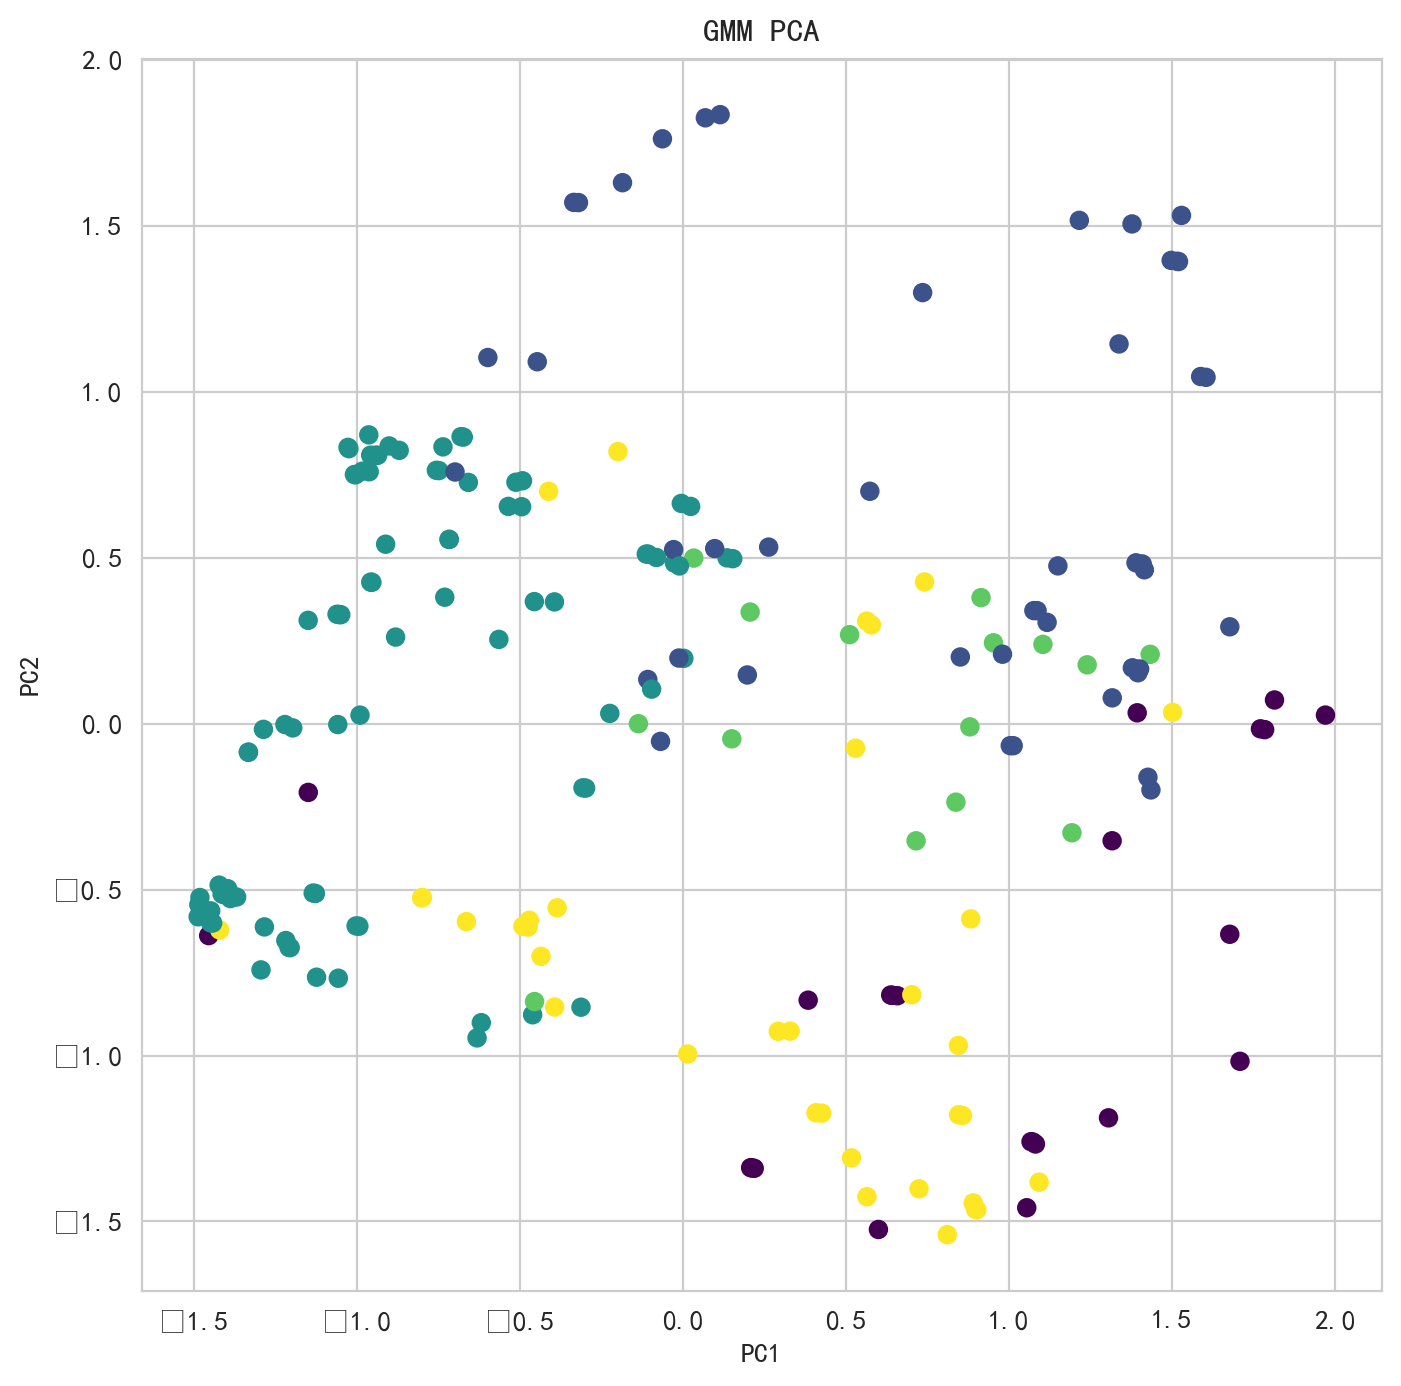

In [28]:
# 绘制聚类结果2维的散点图
car_price = pd.read_csv('after_pca_data.csv')

plt.figure(figsize=(8,8))
plt.scatter(data[:,0], data[:,1], c=y_pred, cmap='viridis')
for ii in np.arange(205):
    # plt.text(data[ii,0],data[ii,1], s=car_price.car_ID[ii])
    plt.text(data[ii,0], data[ii,1], s='')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('GMM PCA')
plt.show()

上面以占比最大的前2个主成分画出的二维散点图，发现右下蓝色这簇部分聚类点距离很远，效果似乎不是很好；而其他四簇效果还好。 考虑到保留的主成分为8个，且前两个主成分累计可解释方差占比仅约为44%，损失信息较多，所以尝试利用前3个主成分画3d效果图再查看。

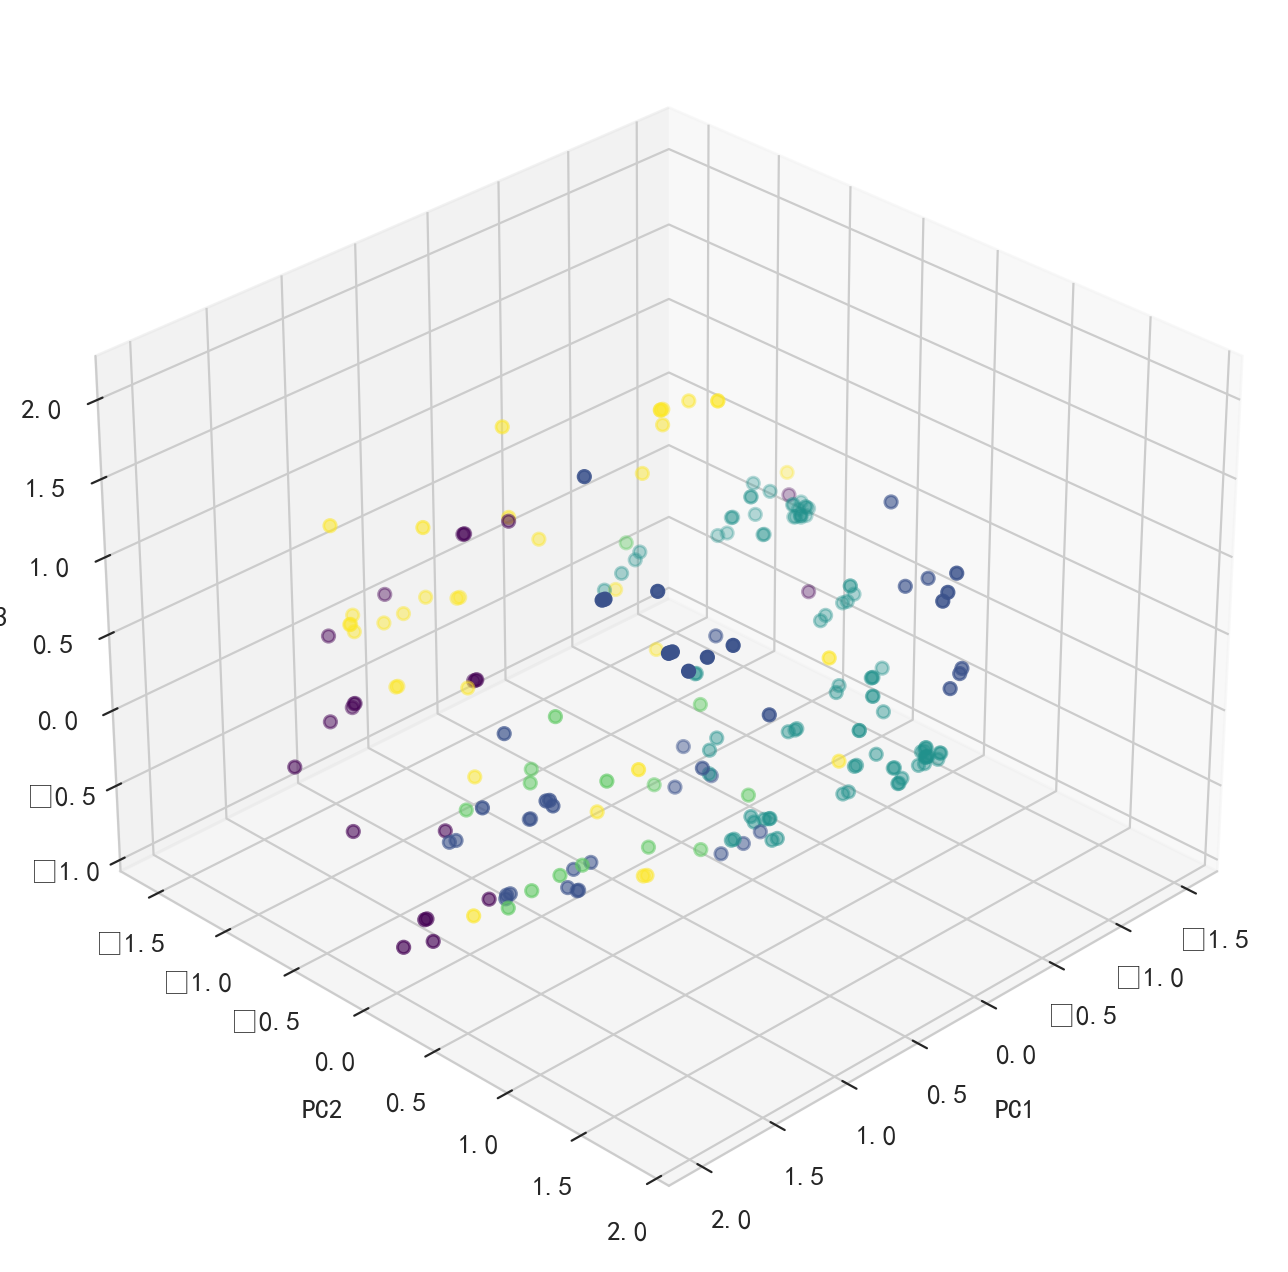

In [29]:
#绘制聚类结果后3d散点图
from mpl_toolkits.mplot3d import Axes3D
plt.figure(figsize=(8,8))
ax=plt.subplot(111,projection='3d')
ax.scatter(data[:,0], data[:,1], data[:,2], c=y_pred, cmap='viridis')
#视角转换，转换后更易看出簇群
ax.view_init(30,45) 
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

In [30]:
# 将聚类后的类目放入原特征数据中
row_data = pd.read_csv('pre_process_data.csv')
row_data['result'] = y_pred

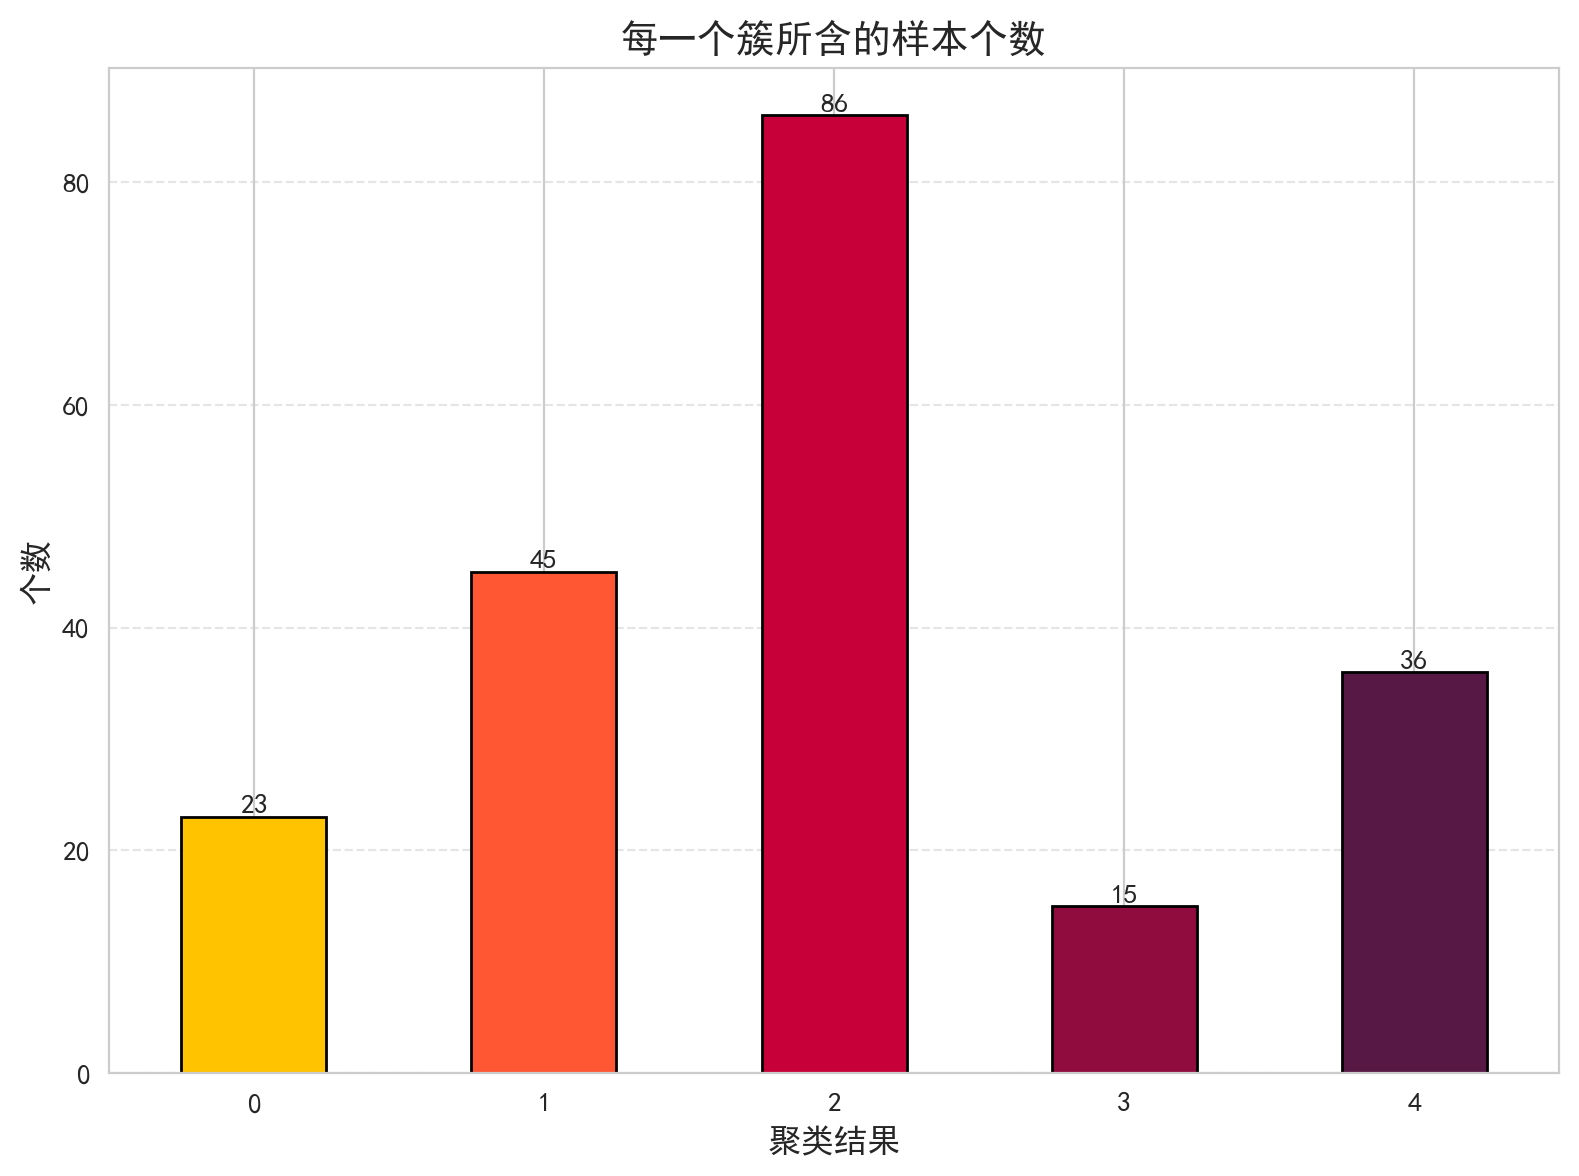

In [31]:
# 聚类结果统计

# 统计聚类后每个集群的车型数
# 假设 row_data 是您的数据DataFrame
result_counts = row_data.groupby('result')['car_ID'].count()

colors = ['#FFC300', '#FF5733', '#C70039', '#900C3F', '#581845']
plt.figure(figsize=(8, 6))
result_counts.plot(kind='bar', color=colors, edgecolor='black')

plt.xlabel('聚类结果', fontsize=12)
plt.ylabel('个数', fontsize=12)
plt.title('每一个簇所含的样本个数', fontsize=14)

plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.5)

for i, v in enumerate(result_counts.values):
    plt.text(i, v, str(v), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [32]:
# 统计每个集群各个品牌的车型数
row_data.groupby(by=['result', 'carBrand'])['car_ID'].count()

result  carBrand   
0       audi            1
        buick           4
        chevrolet       1
        jaguar          3
        mazda           4
        nissan          1
        porsche         4
        toyota          5
1       audi            4
        bmw             1
        buick           4
        dodge           1
        honda           1
        mazda           3
        nissan          1
        peugeot        11
        toyota          3
        volkswagen      6
        volvo          10
2       audi            1
        chevrolet       2
        dodge           6
        honda          11
        isuzu           2
        mazda          10
        mitsubishi      6
        nissan         10
        plymouth        5
        renault         2
        saab            3
        subaru          8
        toyota         15
        volkswagen      5
3       audi            1
        bmw             7
        isuzu           1
        subaru          4
        toyota    

In [33]:
# 统计每个品牌所属各个集群的车型数
row_data.groupby(by=['carBrand','result'])['result'].count()

carBrand     result
alfa-romero  4          3
audi         0          1
             1          4
             2          1
             3          1
bmw          1          1
             3          7
buick        0          4
             1          4
chevrolet    0          1
             2          2
dodge        1          1
             2          6
             4          2
honda        1          1
             2         11
             4          1
isuzu        2          2
             3          1
             4          1
jaguar       0          3
mazda        0          4
             1          3
             2         10
mercury      4          1
mitsubishi   2          6
             4          7
nissan       0          1
             1          1
             2         10
             4          6
peugeot      1         11
plymouth     2          5
             4          2
porsche      0          4
             4          1
renault      2          2
saab         2    

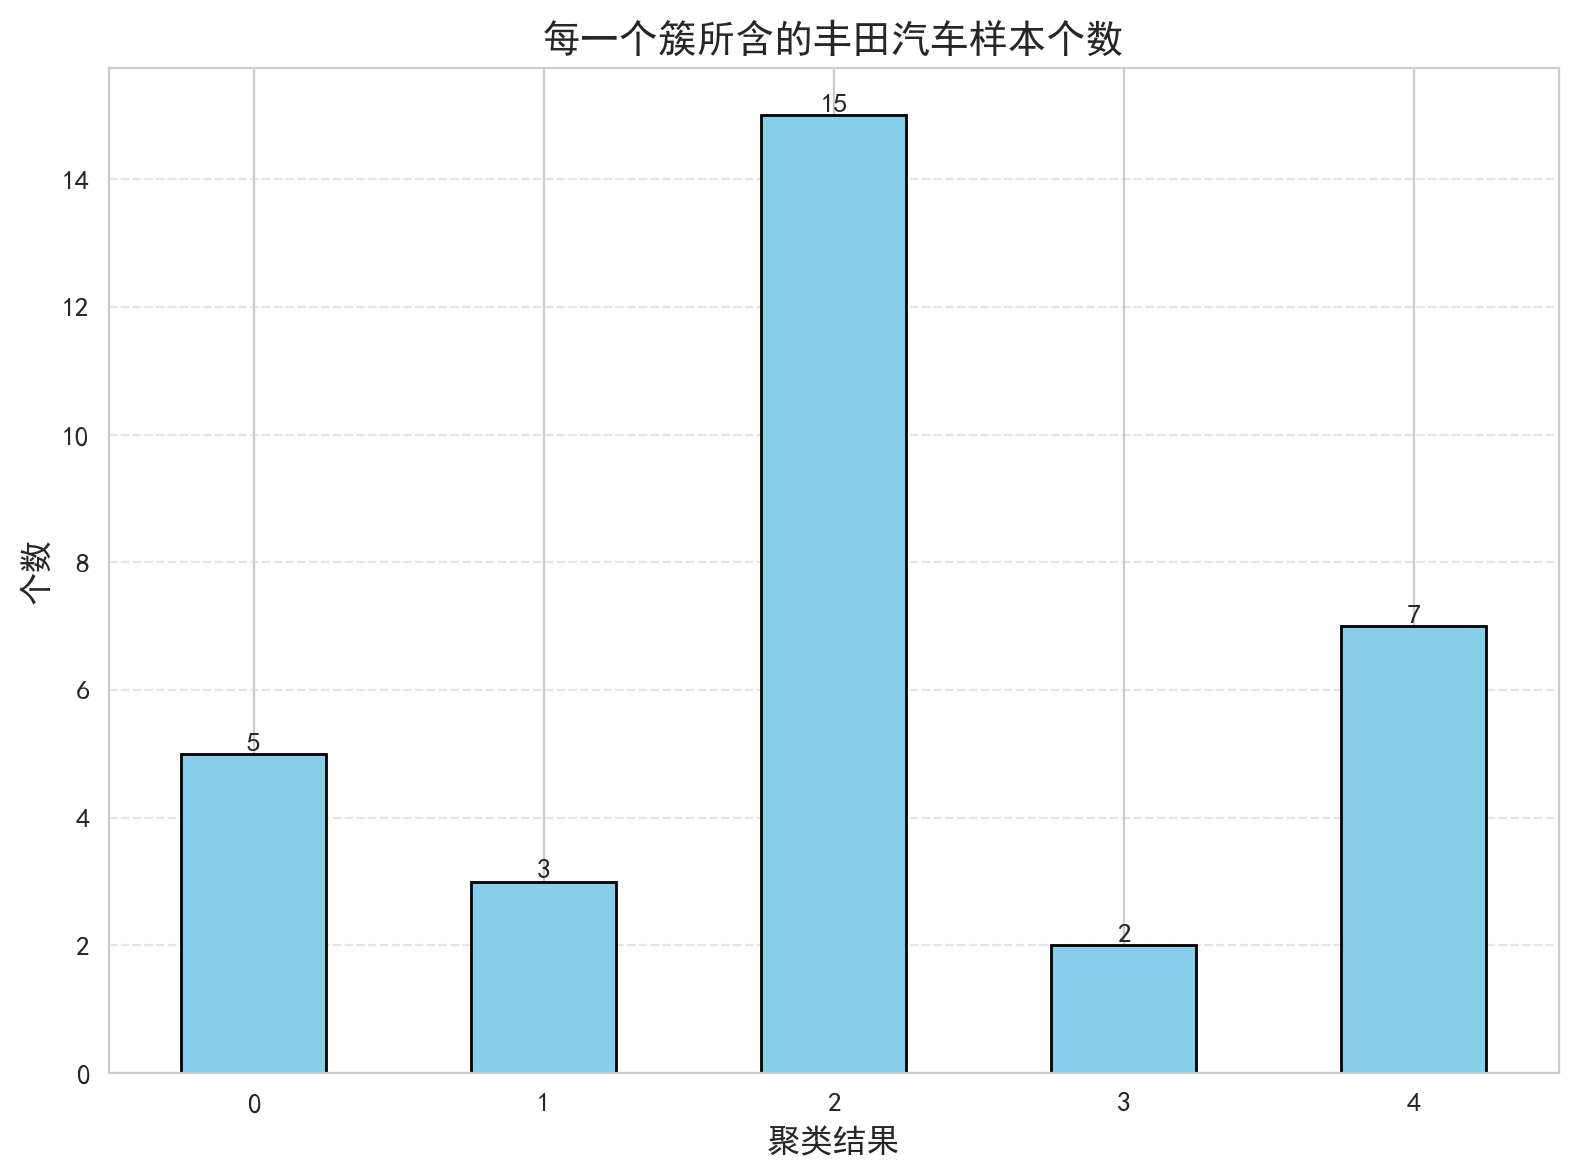

In [34]:
toyota = row_data.loc[row_data['carBrand'] == 'toyota']
tmp = toyota.groupby(by=['result'])['result'].count()

# Set the figure size
plt.figure(figsize=(8, 6))

# Plot the bar chart
tmp.plot(kind='bar', color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('聚类结果', fontsize=12)
plt.ylabel('个数', fontsize=12)
plt.title('每一个簇所含的丰田汽车样本个数', fontsize=14)

# Customize the tick labels and grid lines
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add value labels on top of each bar
for i, v in enumerate(tmp.values):
    plt.text(i, v, str(v), ha='center', va='bottom', fontsize=10)

# Adjust the layout to prevent labels from being cut off
plt.tight_layout()

# Display the graph
plt.show()

In [35]:
# 查看特指车名‘toyota’车型的聚类集群
df = row_data.loc[:,['car_ID','CarName','carBrand','result']]
print(df.loc[df['CarName'].str.contains("toyota")])

     car_ID                    CarName carBrand  result
150     151      toyota corona mark ii   toyota       2
151     152              toyota corona   toyota       2
152     153        toyota corolla 1200   toyota       2
153     154      toyota corona hardtop   toyota       2
154     155   toyota corolla 1600 (sw)   toyota       2
155     156              toyota carina   toyota       2
156     157             toyota mark ii   toyota       2
157     158        toyota corolla 1200   toyota       2
158     159              toyota corona   toyota       1
159     160             toyota corolla   toyota       1
160     161              toyota corona   toyota       2
161     162             toyota corolla   toyota       2
162     163             toyota mark ii   toyota       2
163     164    toyota corolla liftback   toyota       3
164     165              toyota corona   toyota       3
165     166  toyota celica gt liftback   toyota       4
166     167      toyota corolla tercel   toyota 

In [36]:
# 查看大众volkswagen品牌各集群内的竞品车型
df_volk = df.loc[df['result'] == 4].sort_values(by=['result','carBrand'])
df_volk

,car_ID,CarName,carBrand,result
0,1,alfa-romero giulia,alfa-romero,4
1,2,alfa-romero stelvio,alfa-romero,4
2,3,alfa-romero Quadrifoglio,alfa-romero,4
23,24,dodge d200,dodge,4
29,30,dodge coronet custom (sw),dodge,4
30,31,honda civic,honda,4
46,47,isuzu D-Max,isuzu,4
75,76,mercury cougar,mercury,4
79,80,mitsubishi g4,mitsubishi,4
80,81,mitsubishi mirage g4,mitsubishi,4


## 4.3 对'toyota'车型的竞品分析
这里主要针对特指‘toyota’车型的竞品分析，若要分析‘toyota’大众品牌的也可同理按每个集群进行分析。

In [63]:
# 提取分类为0的所有车型特征数据
df0 = row_data.loc[row_data['result']==3]
df0

,Unnamed: 0,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,...,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,carBrand,result
4,4,5,2,audi 100ls,gas,std,4,sedan,4wd,front,...,3.19,3.40,8.0,115,5500,18,22,17460.0,audi,3
10,10,11,2,bmw 320i,gas,std,2,sedan,rwd,front,...,3.50,2.80,8.8,101,5800,23,29,16430.0,bmw,3
12,12,13,0,bmw x1,gas,std,2,sedan,rwd,front,...,3.31,3.19,9.0,121,4250,21,28,20980.0,bmw,3
13,13,14,0,bmw x3,gas,std,4,sedan,rwd,front,...,3.31,3.19,9.0,121,4250,21,28,21100.0,bmw,3
14,14,15,1,bmw z4,gas,std,4,sedan,rwd,front,...,3.31,3.19,9.0,121,4250,20,25,24560.0,bmw,3
15,15,16,0,bmw x4,gas,std,4,sedan,rwd,front,...,3.62,3.39,8.0,182,5400,16,22,30750.0,bmw,3
16,16,17,0,bmw x5,gas,std,2,sedan,rwd,front,...,3.62,3.39,8.0,182,5400,16,22,41300.0,bmw,3
17,17,18,0,bmw x3,gas,std,4,sedan,rwd,front,...,3.62,3.39,8.0,182,5400,15,20,36860.0,bmw,3
43,43,44,0,isuzu MU-X,gas,std,4,sedan,rwd,front,...,3.31,3.23,8.5,78,4800,24,29,6784.0,isuzu,3
143,143,144,0,subaru baja,gas,std,4,sedan,fwd,front,...,3.62,2.64,9.0,94,5200,26,32,9960.0,subaru,3


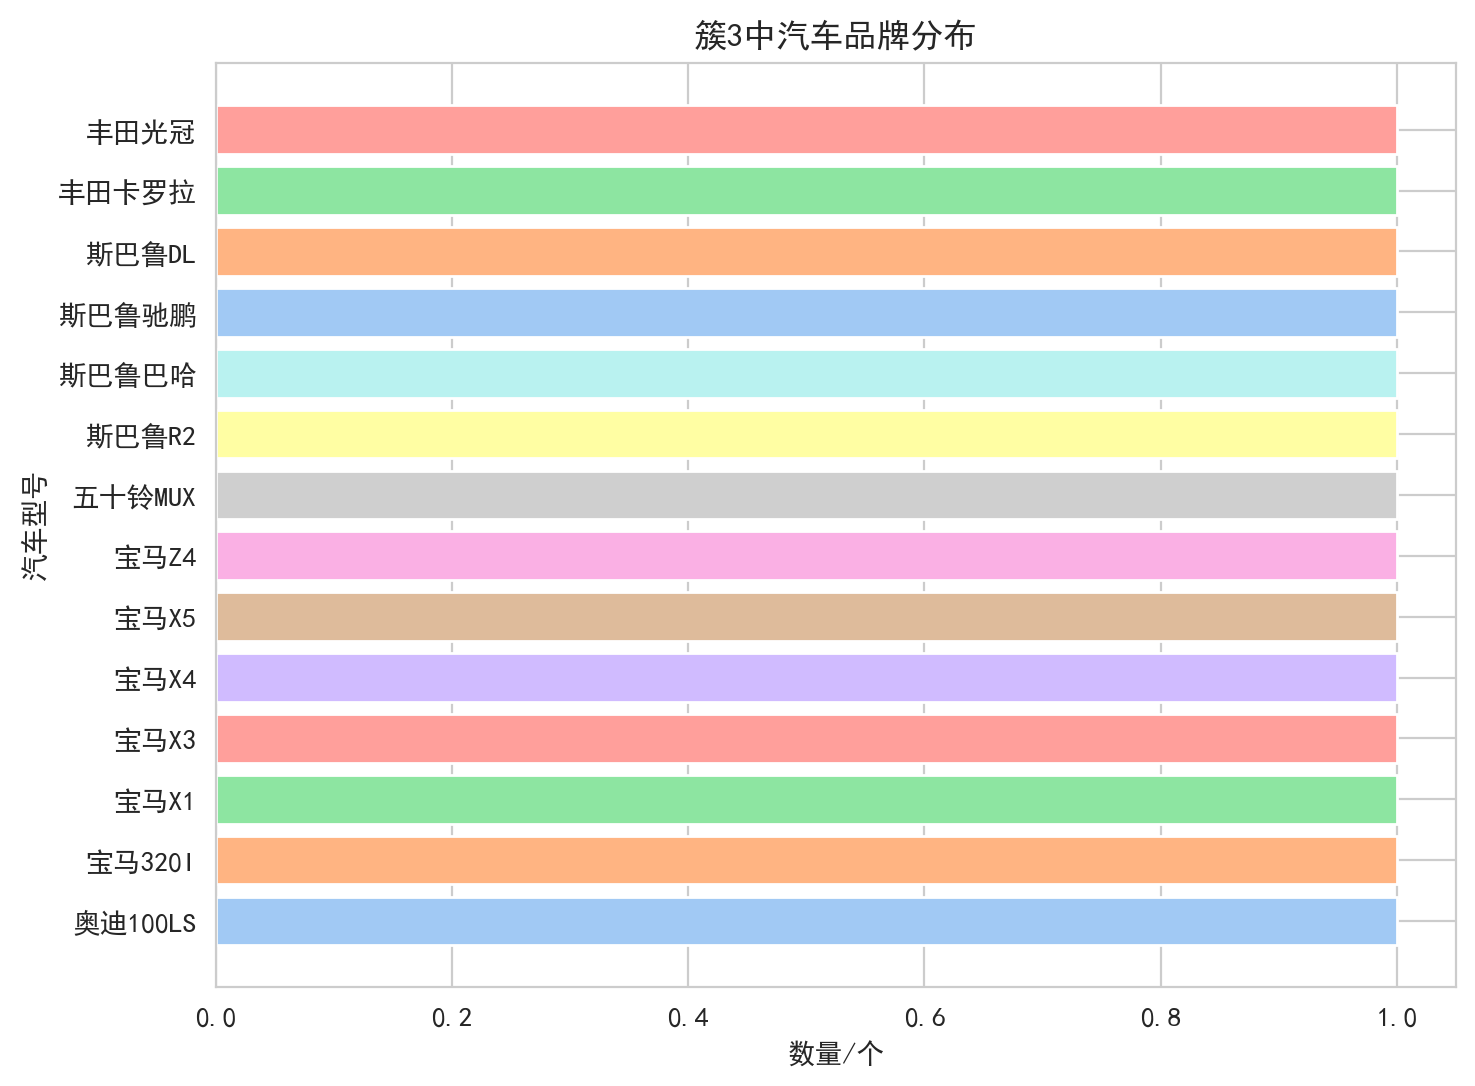

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

# 车型品牌信息
car_brands = [
    '奥迪100LS', '宝马320I', '宝马X1', '宝马X3', '宝马X4', '宝马X5', '宝马Z4',
    '五十铃MUX', '斯巴鲁R2', '斯巴鲁巴哈', '斯巴鲁驰鹏', '斯巴鲁DL',
    '丰田卡罗拉', '丰田光冠'
]

# 统计每个品牌的出现次数
brand_counts = {}
for brand in car_brands:
    if brand in brand_counts:
        brand_counts[brand] += 1
    else:
        brand_counts[brand] = 1

# 提取品牌和出现次数
brands = list(brand_counts.keys())
counts = list(brand_counts.values())

# 设置自定义配色方案
colors = sns.color_palette('pastel')

# 创建水平条形图
plt.figure(figsize=(8, 6))
plt.barh(brands, counts, color=colors)

# 设置图表标题和轴标签
plt.title('簇3中汽车品牌分布')
plt.xlabel('数量/个')
plt.ylabel('汽车型号')

# 显示图表
plt.show()

F:\anaconda\anaconda3\envs\DeltaZero\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


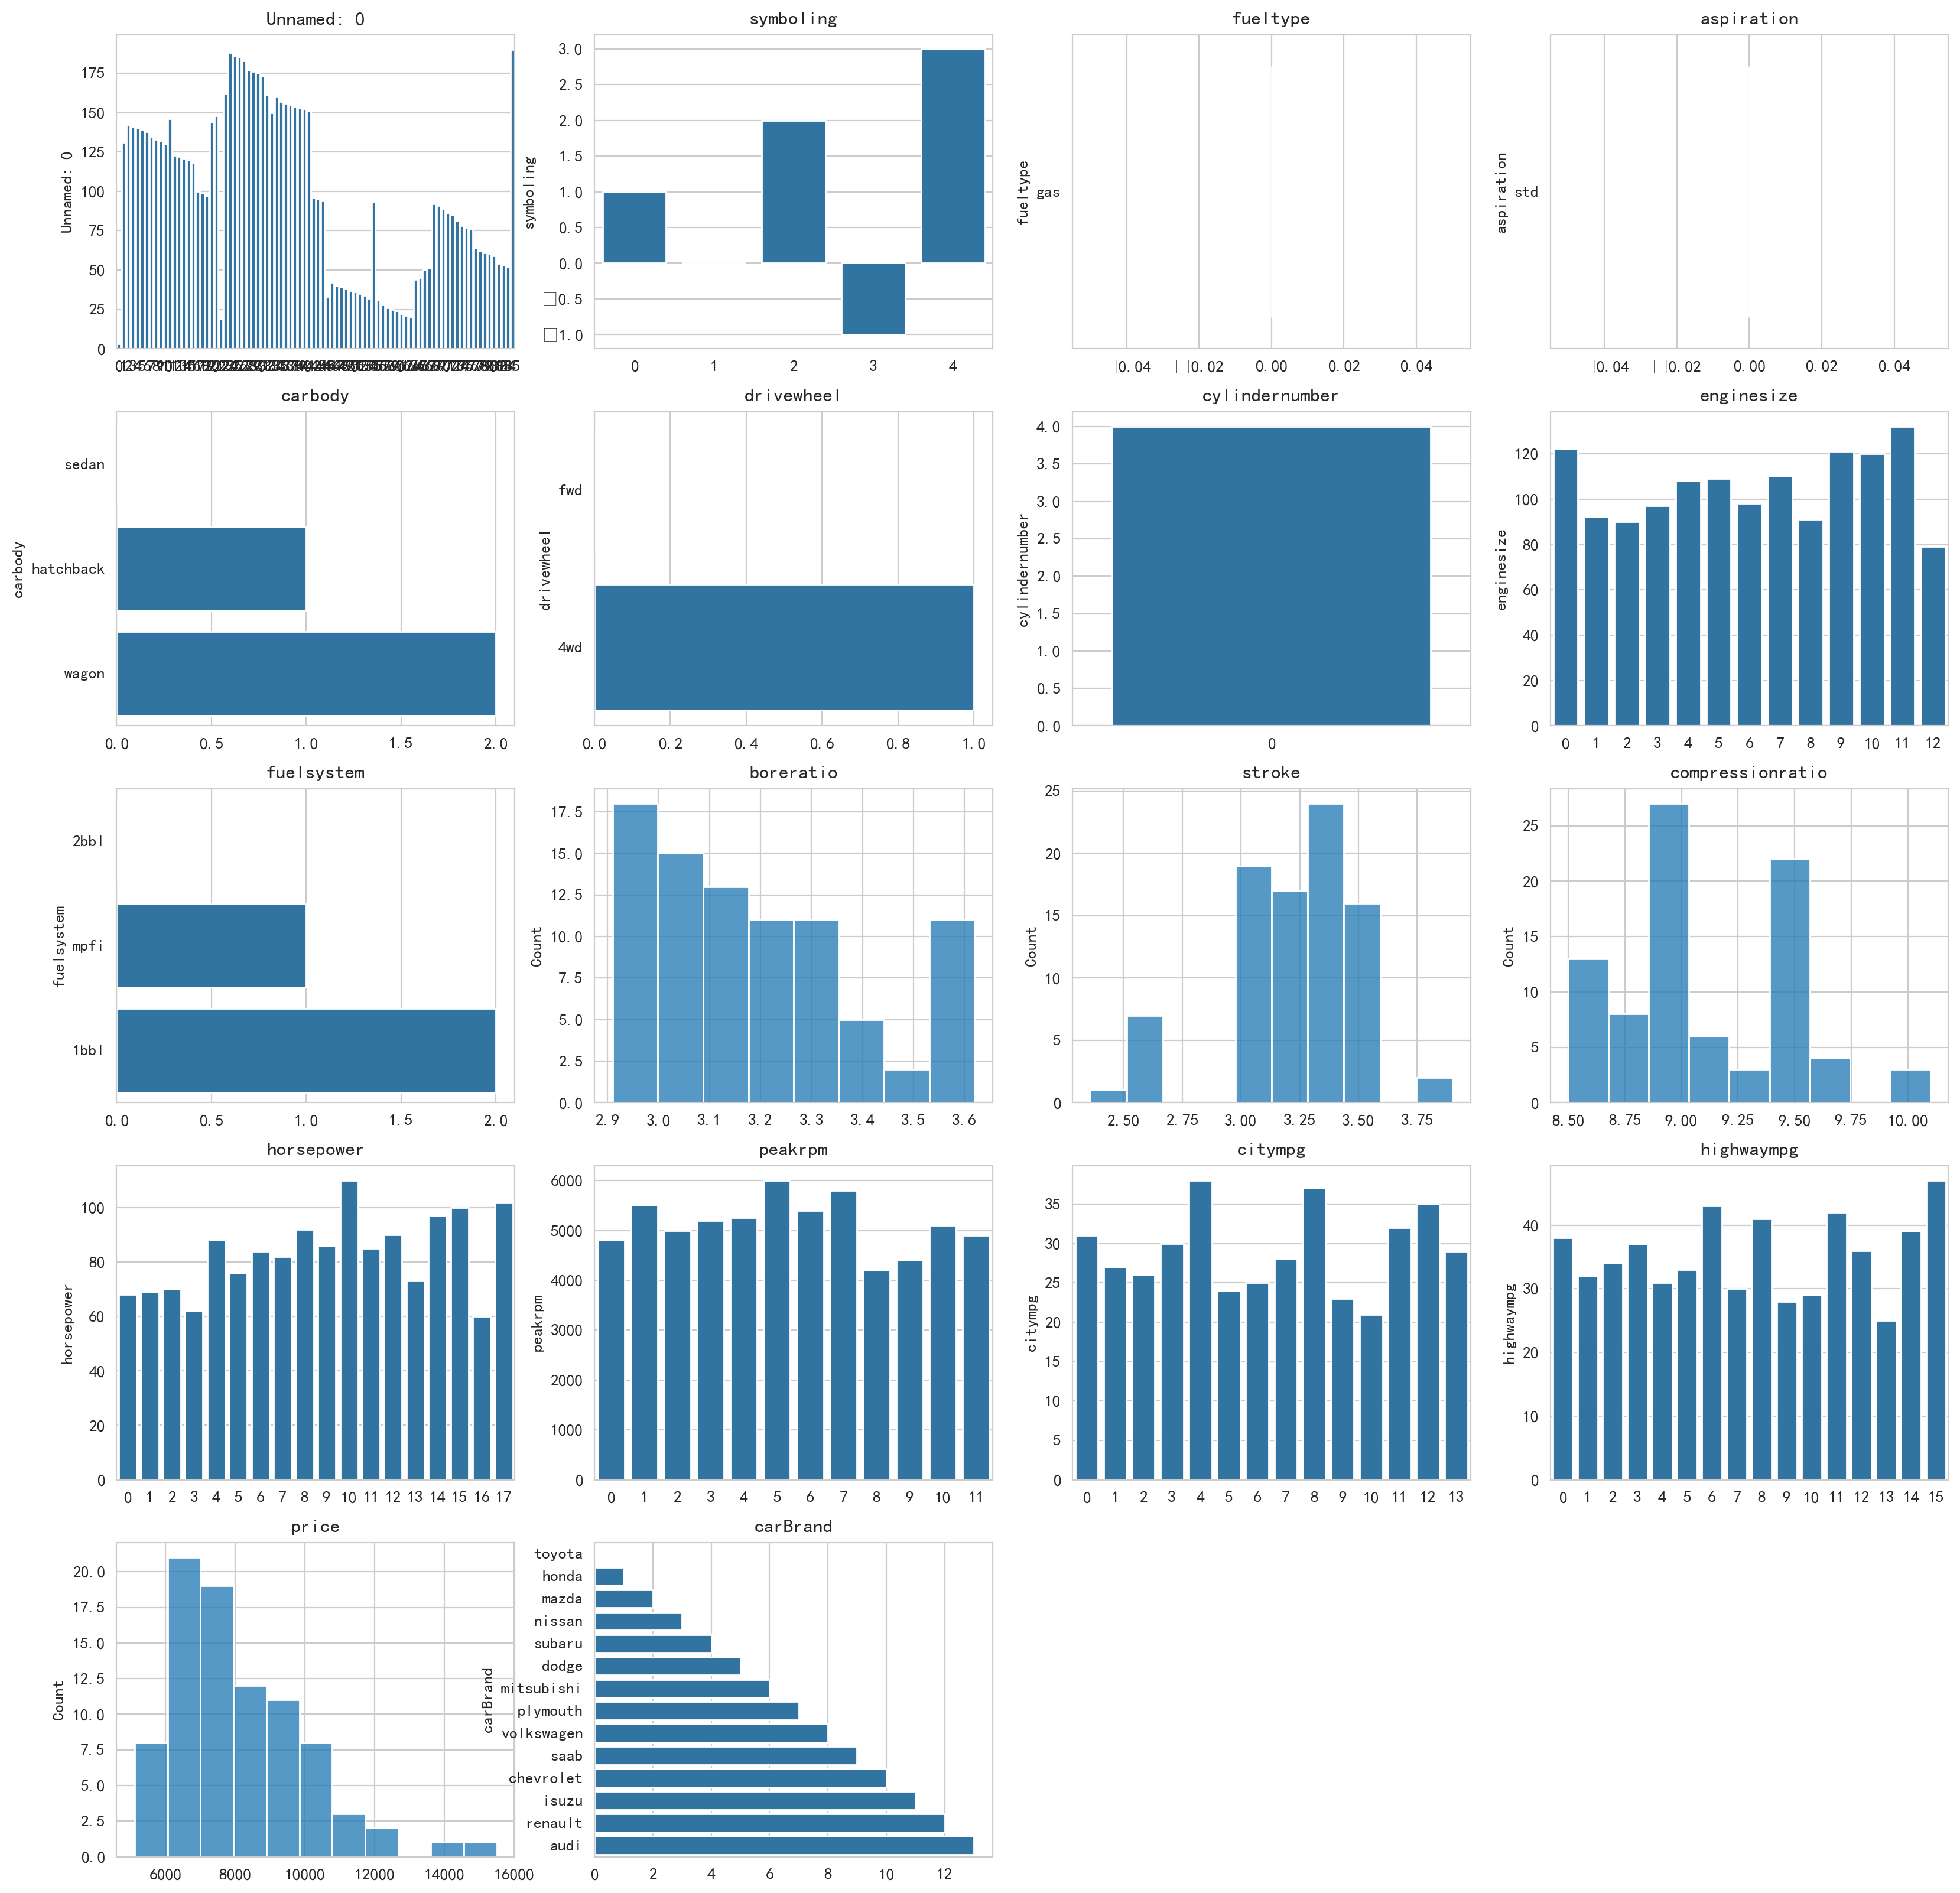

In [57]:
import seaborn as sns

df0_1 = df0.drop(['car_ID','CarName','result'], axis=1)

drop_col = ['doornumber', 'enginelocation', 'carheight', 'wheelbase', 'carlength', 'carwidth', 'curbweight', 'enginetype']

#查看集群4的车型所有特征分布
fig = plt.figure(figsize=(20, 20))
i = 1
for c in df0_1.columns:
    if c in drop_col:
        continue
    ax=fig.add_subplot(7,4,i)
    if df0_1[c].dtypes=='int' or df0_1[c].dtypes=='float':
        sns.histplot(df0_1[c], ax=ax)
    else:
        sns.barplot(df0_1[c].value_counts().index, ax=ax)
    i = i + 1
    plt.xlabel('')
    plt.title(c)  
plt.subplots_adjust(top=1.2)
plt.show()

由集群0的变量特征分布图可知，类别型变量取值只有一种的有：fueltype : {'diesel'}；enginelocation : {'front'}；fuelsystem : {'idi'}；这些共性的特征在竞品分析时可不考虑。

根据乘用车的汽车用户需求特点，一般首先会考虑车型大小级别；而乘用车的对比也是基于同等级别的车型大小进行（如，不可能拿一个D级豪华型车与A级紧凑型车来对比的）。

In [58]:
print(max(df0.carlength))
print(min(df0.carlength))

186.6
144.6


In [98]:
bins = [min(df0.carlength) - 0.01, 176.67, 184.29, 192.10, 200.91, max(df0.carlength) + 0.01]
label = ['A0','A','B','C','D']
carSize = pd.cut(df0.carlength, bins, labels=label)

df0['carSize'] = carSize

C:\Users\dell\AppData\Local\Temp\ipykernel_5604\3486938674.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df0['carSize'] = carSize


In [99]:
drop_list = ['fuelsystem', 'aspiration', 'drivewheel', 'enginelocation', 'enginetype', 'fueltype']
df0 = df0.drop(drop_list, axis=1)

In [54]:
# 把所有预测结果为簇3的车型信息打印出来
cluster3 = row_data[row_data['result'] == 3]
cluster3

,Unnamed: 0,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,...,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,carBrand,result
4,4,5,2,audi 100ls,gas,std,4,sedan,4wd,front,...,3.19,3.40,8.0,115,5500,18,22,17460.0,audi,3
10,10,11,2,bmw 320i,gas,std,2,sedan,rwd,front,...,3.50,2.80,8.8,101,5800,23,29,16430.0,bmw,3
12,12,13,0,bmw x1,gas,std,2,sedan,rwd,front,...,3.31,3.19,9.0,121,4250,21,28,20980.0,bmw,3
13,13,14,0,bmw x3,gas,std,4,sedan,rwd,front,...,3.31,3.19,9.0,121,4250,21,28,21100.0,bmw,3
14,14,15,1,bmw z4,gas,std,4,sedan,rwd,front,...,3.31,3.19,9.0,121,4250,20,25,24560.0,bmw,3
15,15,16,0,bmw x4,gas,std,4,sedan,rwd,front,...,3.62,3.39,8.0,182,5400,16,22,30750.0,bmw,3
16,16,17,0,bmw x5,gas,std,2,sedan,rwd,front,...,3.62,3.39,8.0,182,5400,16,22,41300.0,bmw,3
17,17,18,0,bmw x3,gas,std,4,sedan,rwd,front,...,3.62,3.39,8.0,182,5400,15,20,36860.0,bmw,3
43,43,44,0,isuzu MU-X,gas,std,4,sedan,rwd,front,...,3.31,3.23,8.5,78,4800,24,29,6784.0,isuzu,3
143,143,144,0,subaru baja,gas,std,4,sedan,fwd,front,...,3.62,2.64,9.0,94,5200,26,32,9960.0,subaru,3


In [100]:
# 对不同车型级别、品牌、车身等类型特征进行数据透视
df2 = df0.pivot_table(index=['carSize','carbody','carBrand','CarName'])
df2

Unnamed: 0  \
carSize carbody     carBrand    CarName                                       
A0      convertible alfa-romero alfa-romero giulia                        0   
                                alfa-romero stelvio                       1   
                    toyota      toyota cressida                         172   
        hardtop     toyota      toyota corolla                          168   
                                toyota corona liftback                  167   
                                toyota tercel                           170   
A       convertible buick       buick skylark                            72   
B       hardtop     buick       buick century                            69   
        sedan       buick       buick electra 225 custom                 67   
                    jaguar      jaguar xk                                49   
                    peugeot     peugeot 504                             111   
                                peugeot 604sl                           117   
                    toyota      toyota starlet                          180   
                    volvo       volvo 244dl                             202   
                                volvo 246                               203   
        wagon       buick       buick century luxus (sw)                 68   
                    toyota      toyouta tercel                          181   
C       hardtop     buick       buick regal sport coupe (turbo)          74   
        sedan       jaguar      jaguar xf                                48   
                                jaguar xj                                47   
        wagon       peugeot     peugeot 504                             113   
                                peugeot 504 (sw)                        109   
D       sedan       buick       buick century special                    73   
                                buick opel isuzu deluxe                  71   
                                buick skyhawk                            70   

                                                                 boreratio  \
carSize carbody     carBrand    CarName                                      
A0      convertible alfa-romero alfa-romero giulia                    3.47   
                                alfa-romero stelvio                   3.47   
                    toyota      toyota cressida                       3.62   
        hardtop     toyota      toyota corolla                        3.62   
                                toyota corona liftback                3.62   
                                toyota tercel                         3.62   
A       convertible buick       buick skylark                         3.46   
B       hardtop     buick       buick century                         3.58   
        sedan       buick       buick electra 225 custom              3.58   
                    jaguar      jaguar xk                             3.54   
                    peugeot     peugeot 504                           3.46   
                                peugeot 604sl                         3.61   
                    toyota      toyota starlet                        3.27   
                    volvo       volvo 244dl                           3.58   
                                volvo 246                             3.01   
        wagon       buick       buick century luxus (sw)              3.58   
                    toyota      toyouta tercel                        3.27   
C       hardtop     buick       buick regal sport coupe (turbo)       3.80   
        sedan       jaguar      jaguar xf                             3.63   
                                jaguar xj                             3.63   
        wagon       peugeot     peugeot 504                           3.46   
                                peugeot 504 (sw)                      3.46   
D       sedan       buick       buick century special      

In [76]:
df0

,Unnamed: 0,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,...,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,carBrand,result,carSize
0,0,1,3,alfa-romero giulia,gas,std,2,convertible,rwd,front,...,2.680,9.00,111,5000,21,27,13496.0,alfa-romero,4,A
1,1,2,3,alfa-romero stelvio,gas,std,2,convertible,rwd,front,...,2.680,9.00,111,5000,21,27,16500.0,alfa-romero,4,A
2,2,3,1,alfa-romero Quadrifoglio,gas,std,2,hatchback,rwd,front,...,3.470,9.00,154,5000,19,26,16500.0,alfa-romero,4,B
23,23,24,1,dodge d200,gas,turbo,2,hatchback,fwd,front,...,3.390,7.60,102,5500,24,30,7956.0,dodge,4,A0
46,46,47,2,isuzu D-Max,gas,std,2,hatchback,rwd,front,...,3.230,9.20,90,5000,24,29,11050.0,isuzu,4,B
55,55,56,3,mazda 626,gas,std,2,hatchback,rwd,front,...,3.256,9.40,101,6000,17,23,10940.0,mazda,4,A
56,56,57,3,mazda glc,gas,std,2,hatchback,rwd,front,...,3.256,9.40,101,6000,17,23,11850.0,mazda,4,A
57,57,58,3,mazda rx-7 gs,gas,std,2,hatchback,rwd,front,...,3.256,9.40,101,6000,17,23,13650.0,mazda,4,A
58,58,59,3,mazda glc 4,gas,std,2,hatchback,rwd,front,...,3.256,9.40,135,6000,16,23,15650.0,mazda,4,A
72,72,73,3,buick skylark,gas,std,2,convertible,rwd,front,...,3.100,8.30,155,4750,16,18,35070.0,buick,4,C
